# **1) Data Preparation**

From the original full BindingDB database, we extracted a smaller, more manageable dataset by selecting only ligand-target pairs studied on viral organisms associated with sexually transmitted diseases, such as Human Immunodeficiency Virus (HIV). This subset is saved in the same `.tsv` file format as the original database.

For more details on the extraction process, refer to [`./src/data/std_extraction.ipynb`](./src/data/std_extraction.ipynb).


In [99]:
#import libraries and scripts

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import data_utils, evaluation_utils
from src.data.some_dataloader import get_dataset
from src.scripts import rdkit_extraction
from src.utils import evaluation_utils

#imports to get rid of Morgan Fingerprint warnings
import warnings
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')

#set seaborn palette
sns.set_palette('colorblind')

We import the reduced dataset with the custom dataloader `get_dataset`. The reduced dataset contains only viruses responsible for STDs as target organisms

In [102]:
#read the std database

df = get_dataset()
print(f'STDs dataset rows: {df.shape[0]}')
print(f'STDs dataset columns: {df.shape[1]}')

STDs dataset rows: 30156
STDs dataset columns: 86


In the dataset, four affinity metric are available:

1. **Ki (Inhibition Constant)**: Represents the concentration at which an inhibitor ligand occupies 50% of the receptor or enzyme sites, assuming no competing ligands are present. It quantifies the affinity of the inhibitor for the target under equilibrium conditions.

2. **IC50 (Half Maximal Inhibitory Concentration)**: Represents the concentration of a drug needed to inhibit a specific biological or biochemical function by 50%. It measures how much drug is required to achieve a halfway inhibition of the target activity in a given experimental setup.

3. **Kd (Dissociation Constant)**: Represents the concentration at which 50% of the binding sites on the target (e.g., receptor or enzyme) are occupied by the ligand. It quantifies the equilibrium affinity between a ligand and its target, with lower values indicating tighter binding.

4. **EC50 (Half Maximal Effective Concentration)**: Represents the concentration of a drug needed to produce 50% of its maximal effect in a biological system. It is an indicator of the drug's potency, reflecting the concentration required to achieve a halfway maximal response.

These metrics are interrelated but not directly interchangeable, although an approximate relationship between **Ki** and **IC50**, the Cheng-Prusoff equation, does exist. Unfortunately, strict conditions need to be satisfies, so we won't use it in our analysis.

Therefore, in the next cells we will select the most represented metric in our dataset and get rid of rows where it's not provided.

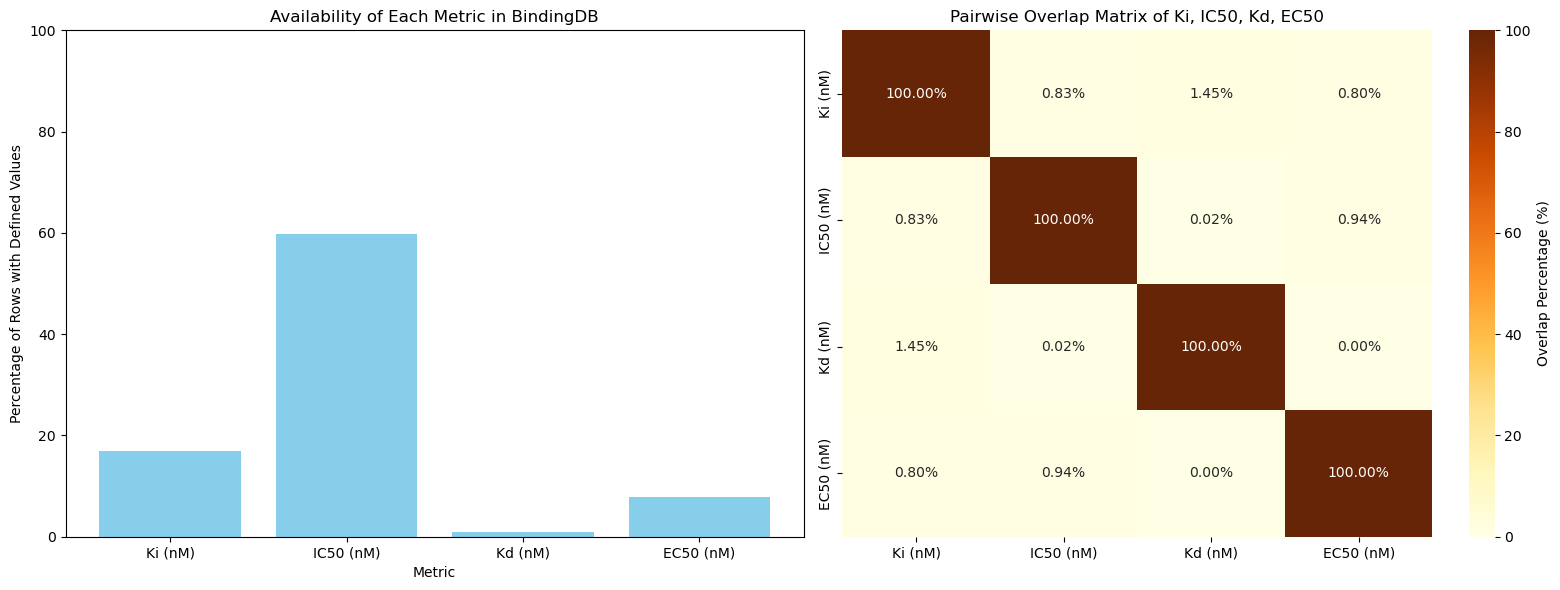

In [104]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax = axes.flatten()

evaluation_utils.plot_metric_availability(df, ax=ax[0])
evaluation_utils.plot_overlap_matrix(df, ax=ax[1])

plt.tight_layout()
plt.show()

We observe that IC50 is given in more than 50% of the rows, while the other metrics are less represented. In the overlap matrix, we also observe that metrics rarely overlap, so it makes sense to pick only one of the four for the analysis.  

In the next cell, we use the `data_utils.select_metric` function to select only rows with IC50 for our analyses.  

We also get rid of columns where more than 50% of entries are `NaN` through the `data_utils.clean_na_columns` function. Non-numeric entries that were not `NaN` (e.g., `'> 50000'`) were also removed, since they would negatively affect the computation of statistics like the mean.



In [106]:
df = data_utils.select_metric(df, 'IC50 (nM)')
df = data_utils.clean_na_columns(df)
print(f'Rows of STD dataset where IC50 is given: {df.shape[0]}')
print(f'Columns of STD dataset where nan rows are less than 50% of the total: {df.shape[1]}')

Rows of STD dataset where IC50 is given: 18026
Columns of STD dataset where nan rows are less than 50% of the total: 27


Let's now plot with the `evaluation_utils.plot_organism_counts` function the frequencies of entries for all targets. The distribution we obtain is skewed, so we employ a logarithmic scale

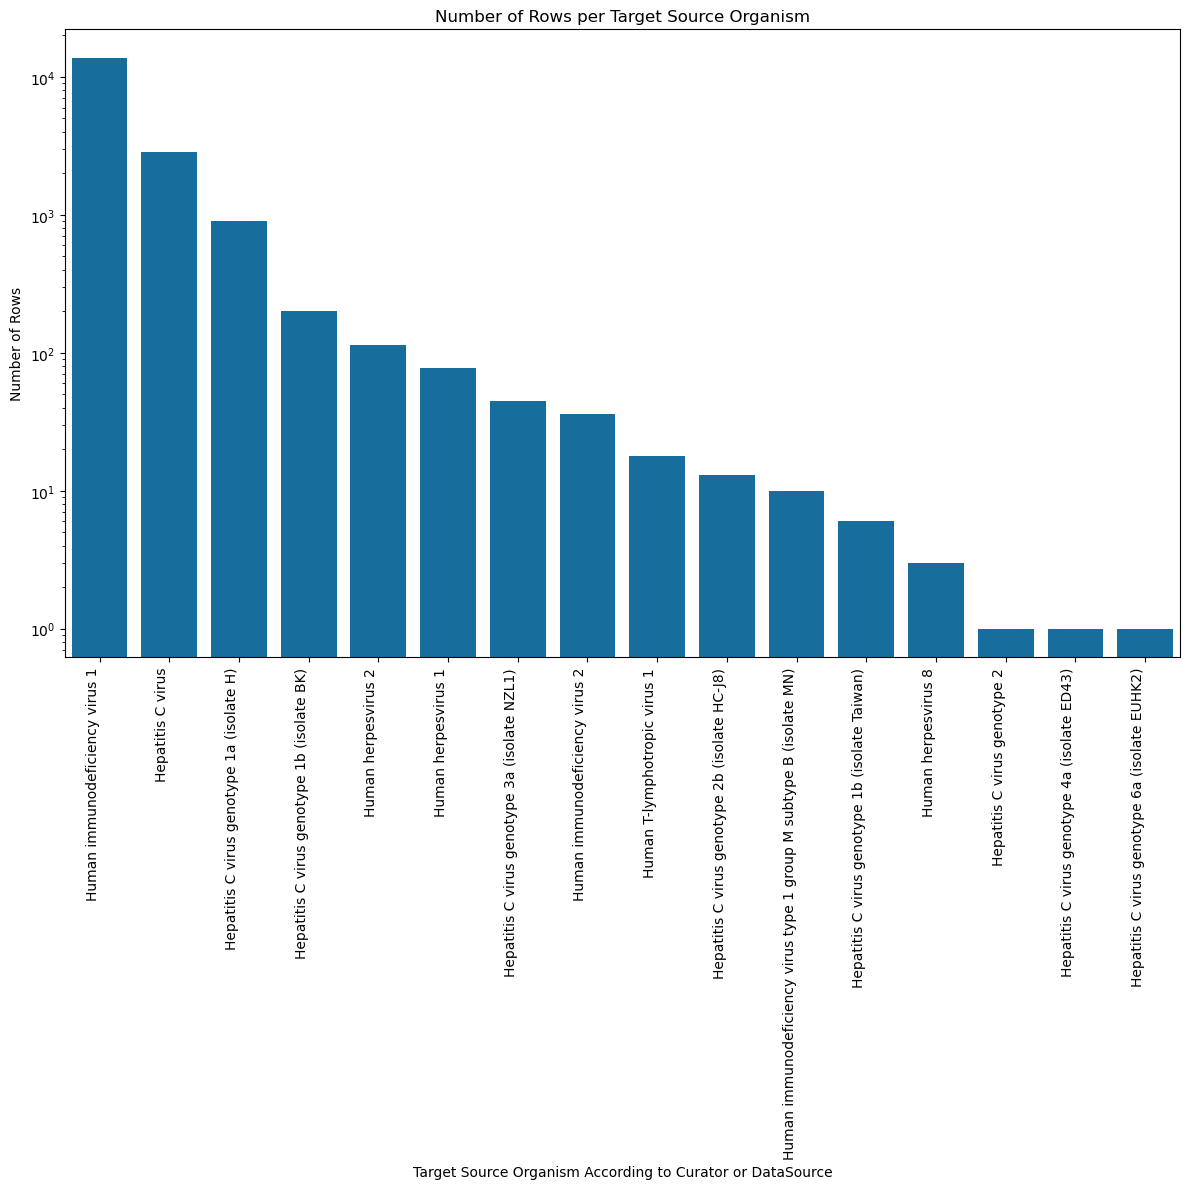

In [109]:
evaluation_utils.plot_organism_counts(df)

We observe that HIV 1 is clearly the most represented in the dataset (this type accounts for more than 95% of HIV infections worldwide (see https://doi.org/10.1093/infdis/jiad327)). The second most represented in the dataset is Hepatitis C virus.

This study focuses on the HIV 1 subset of sexually transmitted diseases (STDs), investigating how specific features influence the affinity of STD drugs. The analyzed features include Year, Institution, Molecular Features, Types of Drugs, and Type of Protein Target. These features were selected because they represent critical aspects of drug development and application, offering a solid foundation for understanding patterns and structures associated with drug affinity.

Additionally, a comparative analysis with Hepatitis C will be conducted to identify differences and similarities with HIV 1, providing broader context and depth to the analysis.

By focusing on these two viruses, we aim to underscore their social relevance by addressing the ongoing global health challenges they pose and shedding light on opportunities to improve therapeutic strategies for diseases that disproportionately affect vulnerable populations. STDs.

In [116]:
#Let's create a new `hiv` dataframe, containing only rows where the target is `Human immunodeficiency virus 1`
hiv = df[df['Target Source Organism According to Curator or DataSource'] == 'Human immunodeficiency virus 1']
print(f'HIV1 dataset rows: {hiv.shape[0]}')
print(f'HIV1 dataset columns: {hiv.shape[1]}')
#let's do it for Hepatites C
##LEONORS CODE

HIV1 dataset rows: 13754
HIV1 dataset columns: 27


For future analysis it would be useful to have a column in the dataset representing the year of when the study on that drug was conducted: (if we do the feature 'year' this igoing to there)


In [155]:
#create new df containing the DOI's
hiv_doi = hiv.copy()
doi_df = hiv_doi['Article DOI'].value_counts().reset_index()
# Applying  function 'get_publication_year' to each DOI in the dataframe:
doi_df['year'] = doi_df['Article DOI'].apply(lambda x : data_utils.get_publication_year(x))
doi_df
##merging the dataset to have a column contain the year
hiv_doi = pd.merge(hiv_doi, doi_df, on='Article DOI', how='outer')

# **2) Feature analysis**

The features we are going to analyze are:

- **Year**: To examine temporal trends in drug affinity, such as advancements in treatment effectiveness or changes in focus over time.
- **Institution**: To explore the contributions of different research organizations, including geographic and resource-based disparities, to the development of STD drugs.
- **Molecular Features**: To assess how the chemical and biological properties of compounds influence their affinity for STD-related targets.
- **Drug Categories**: To classify and compare the effectiveness of different drug categories (e.g., antiretrovirals or antivirals) in treating STDs.
- **Protein Target**: To understand the interaction between drugs and specific biological targets, providing insights into the mechanisms driving drug efficacy.
icacy.


## **Protein Target**


Let's begin our journey of the features with *Protein Target*, which refers to the specific biological molecules, often proteins, that drugs interact with to exert their therapeutic effects. By studying protein targets, we can gain valuable insights into the mechanisms of action for different drugs and how the target influences the affinity of the drug.

To better understand which types of drugs have been studied in the fight against HIV-1, we will explore the data on the most commonly targeted proteins. These proteins are pivotal in the replication and survival of the virus, making them critical points of intervention for therapeutic strategies.

To begin, let's have a look at the most targeted proteins:
t.



In [118]:
hiv['Target Name'] = hiv['Target Name'].str.replace("Dimer of ", "", regex=False)
hiv['Target Name'] = hiv['Target Name'].str.replace("Reverse transcriptase protein", "Reverse transcriptase", regex=False)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning) #ignore warning

C:\Users\defer\AppData\Local\Temp\ipykernel_31836\3320942203.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hiv['Target Name'] = hiv['Target Name'].str.replace("Dimer of ", "", regex=False)
C:\Users\defer\AppData\Local\Temp\ipykernel_31836\3320942203.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hiv['Target Name'] = hiv['Target Name'].str.replace("Reverse transcriptase protein", "Reverse transcriptase", regex=False)


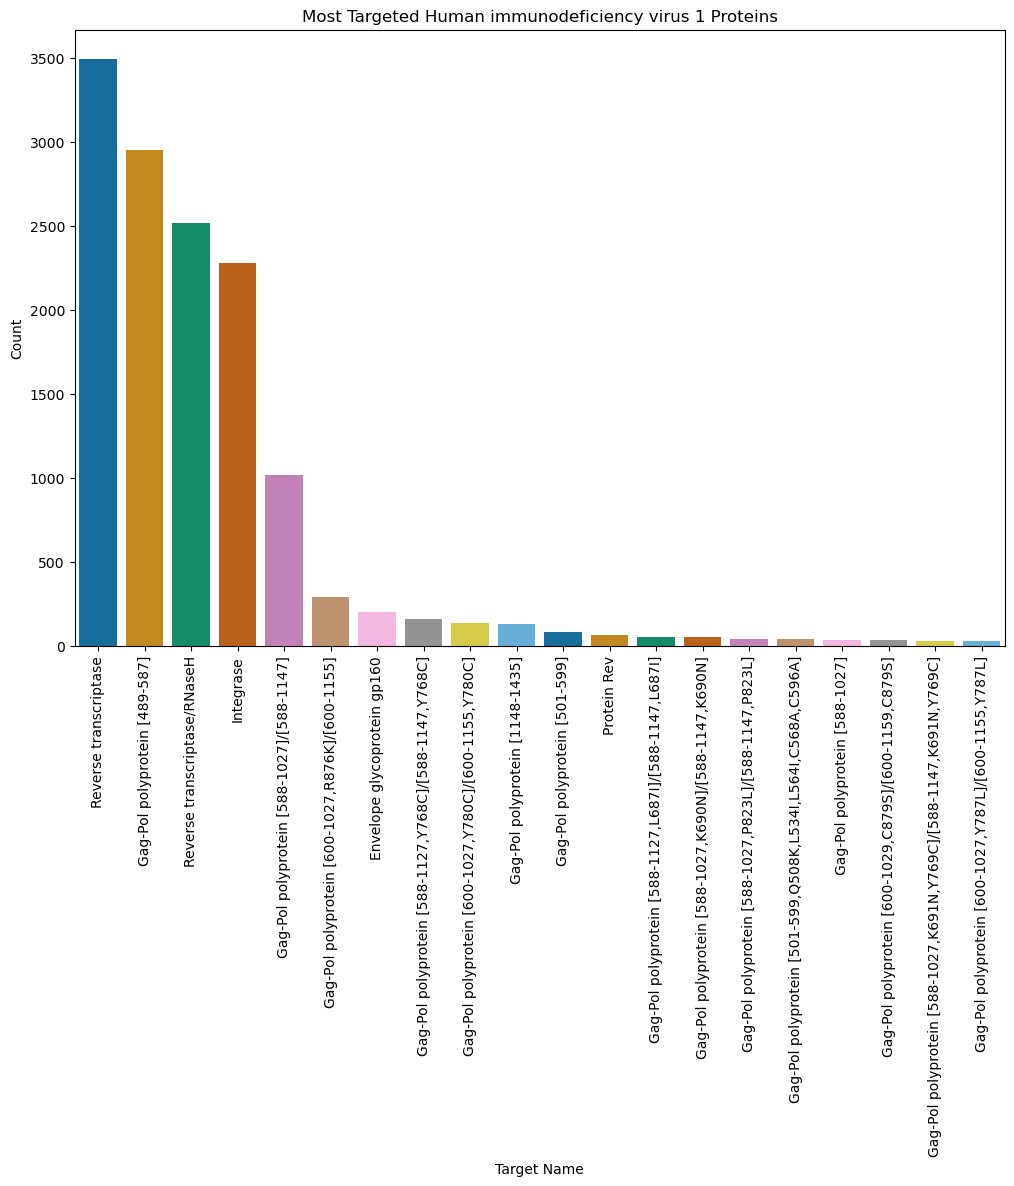

In [121]:
evaluation_utils.plot_most_targeted_proteins(hiv)

### Targeted HIV-1 Proteins

We clearly see that the most targeted proteins in HIV-1 are:

- **Reverse transcriptase**
- **Gag-Pol polyprotein**
- **Integrase**

#### Reverse Transcriptase
Reverse transcriptase is an enzyme that plays a critical role in the HIV lifecycle by converting the virus's single-stranded RNA genome into double-stranded DNA once the virus enters a host cell. This conversion allows the viral DNA to integrate into the host’s genome, a necessary step for HIV replication.

Due to its essential function, reverse transcriptase is a major target for antiretroviral drugs. Two primary classes of inhibitors target this enzyme:
- **Nucleoside Reverse Transcriptase Inhibitors (NRTIs)**: These drugs mimic DNA building blocks, causing premature termination of the DNA chain and stopping HIV replication.
- **Non-Nucleoside Reverse Transcriptase Inhibitors (NNRTIs)**: These drugs bind directly to reverse transcriptase, blocking its activity by altering the enzyme's shape.

#### Gag-Pol Polyprotein
The Gag-Pol polyprotein is a precursor protein produced from the HIV genome that contains multiple essential viral components, including reverse transcriptase, protease, and integrase. During viral maturation, the Gag-Pol polyprotein is cleaved into its functional proteins by the **protease** enzyme, allowing the formation of mature, infectious viral particles.

**Protease inhibitors** are a class of antiretroviral drugs that specifically target the protease enzyme within the Gag-Pol polyprotein. By inhibiting protease, these drugs prevent the cleavage of Gag-Pol, halting the maturation of new viral particles and rendering them non-infectious.

#### Integrase
Integrase is another enzyme within the Gag-Pol polyprotein that facilitates the integration of HIV's DNA into the host cell's genome. This integration is a crucial step in establishing a permanent infection. **Integrase inhibitors** target this enzyme, blocking the integration process and thus preventing HIV from establishing a foothold within host cells.

In [127]:
####add other analysis on protein target(ELI)

## **Drug Categories**

Building on our exploration of protein targets, we now turn to Drug Categories, which are closely tied to the type of targeted protein. A drug category refers to a classification of drugs based on their mechanism of action, the biological pathway they target, or their role in disrupting the viral life cycle.

Understanding drug categories is crucial for studying affinity, as it allows us to analyze how different classes of drugs interact with their respective targets. This can reveal patterns in effectiveness, specificity, and resistance mechanisms, ultimately guiding the development of more efficient therapeutic strategi.
#### Drug Classes for HIV Treatment
The type of targeted protein often determines the class of drug used. For example:
- **NRTIs and NNRTIs** target reverse transcriptase.
- **Protease inhibitors** target the protease enzyme within the Gag-Pol polyprotein.
- **Integrase inhibitors** target integrase to block the integration step.




Following a literature review, we identified the book *[HIV Antiretroviral Therapy](https://www.ncbi.nlm.nih.gov/books/NBK513308/)* as a valuable resource. From this, we developed a preliminary dictionary that categorizes antiretroviral drugs based on their mechanisms of action. es

In [138]:
###drug dictionary based on classes ( reported also ligand inchi key as tool to identify the drugs in the binding db) 

drug_class_dict = {
    # RTIs (NRTIs)
    'HBOMLICNUCNMMY-XLPZGREQSA-N': 'RTI (NRTI)',  # Zidovudine (AZT)
    'JTEGQNOMFQHVDC-NKWVEPMBSA-N': 'RTI (NRTI)',  # Lamivudine (3TC)
    'XQSPYNMVSIKCOC-NTSWFWBYSA-N': 'RTI (NRTI)',  # Emtricitabine (FTC)
    'VCMJCVGFSROFHV-WZGZYPNHSA-N': 'RTI (NRTI)',  # Tenofovir (TDF)   MISSING
    'LDEKQSIMHVQZJK-CAQYMETFSA-N': 'RTI (NRTI)',  # Tenofovir alafenamide (TAF) MISSING
    
    # RTIs (NNRTIs)
    'XPOQHMRABVBWPR-ZDUSSCGKSA-N': 'RTI (NNRTI)', # Efavirenz (EFV)
    'NQDJXKOVJZTUJA-UHFFFAOYSA-N': 'RTI (NNRTI)', # Nevirapine (NVP)
    'WUZMTDIGJDWGJM-UHFFFAOYSA-N': 'RTI (NNRTI)', # Etravirine (ETR) MISSING
    'GIJXKZJWITVLHI-UHFFFAOYSA-N': 'RTI (NNRTI)', # Rilpivirine (RPV)
    
    # Protease Inhibitors (PIs)
    'NCDNCNXCDXHOMX-XGKFQTDJSA-N': 'PI',          # Ritonavir (RTV)
    'KJHKTHWMRKYKJE-SUGCFTRWSA-N': 'PI',          # Lopinavir (LPV)
    'AXRYRYVKAWYZBR-GASGPIRDSA-N': 'PI',          # Atazanavir (ATV)
    'CJBJHOAVZSMMDJ-HEXNFIEUSA-N': 'PI',          # Darunavir (DRV)
    'QWAXKHKRTORLEM-UGJKXSETSA-N': 'PI',          # Saquinavir (SQV)
    
    # Integrase Strand Transfer Inhibitors (INSTIs)
    'CZFFBEXEKNGXKS-UHFFFAOYSA-N': 'INSTI',       # Raltegravir (RAL)
    'RHWKPHLQXYSBKR-BMIGLBTASA-N': 'INSTI',       # Dolutegravir (DTG)
    'JUZYLCPPVHEVSV-LJQANCHMSA-N': 'INSTI',       # Elvitegravir (EVG)
    'SOLUWJRYJLAZCX-LYOVBCGYSA-N': 'INSTI'        # Bictegravir (BIC)
}


drug_name_dict = {
    # RTIs (NRTIs)
    'HBOMLICNUCNMMY-XLPZGREQSA-N': 'Zidovudine',
    'JTEGQNOMFQHVDC-NKWVEPMBSA-N': 'Lamivudine',
    'XQSPYNMVSIKCOC-NTSWFWBYSA-N': 'Emtricitabine',
    'VCMJCVGFSROFHV-WZGZYPNHSA-N': 'Tenofovir',
    'LDEKQSIMHVQZJK-CAQYMETFSA-N': 'Tenofovir alafenamide',
    
    # RTIs (NNRTIs)
    'XPOQHMRABVBWPR-ZDUSSCGKSA-N': 'Efavirenz',
    'NQDJXKOVJZTUJA-UHFFFAOYSA-N': 'Nevirapine',
    'WUZMTDIGJDWGJM-UHFFFAOYSA-N': 'Etravirine',
    'GIJXKZJWITVLHI-UHFFFAOYSA-N': 'Rilpivirine',
    
    # Protease Inhibitors (PIs)
    'NCDNCNXCDXHOMX-XGKFQTDJSA-N': 'Ritonavir',
    'KJHKTHWMRKYKJE-SUGCFTRWSA-N': 'Lopinavir',
    'AXRYRYVKAWYZBR-GASGPIRDSA-N': 'Atazanavir',
    'CJBJHOAVZSMMDJ-HEXNFIEUSA-N': 'Darunavir',
    'QWAXKHKRTORLEM-UGJKXSETSA-N': 'Saquinavir',
    
    # Integrase Strand Transfer Inhibitors (INSTIs)
    'CZFFBEXEKNGXKS-UHFFFAOYSA-N': 'Raltegravir',
    'RHWKPHLQXYSBKR-BMIGLBTASA-N': 'Dolutegravir',
    'JUZYLCPPVHEVSV-LJQANCHMSA-N': 'Elvitegravir',
    'SOLUWJRYJLAZCX-LYOVBCGYSA-N': 'Bictegravir'
}

In [141]:
# Filter the dataset to include only rows with Ligand InChI Key present in drug_class_dict
filtered_data = hiv[hiv['Ligand InChI Key'].isin(drug_class_dict.keys())].copy()

# Adding a new column 'Drug_Class' with the drug class based on the dictionary
filtered_data['Drug_Class'] = filtered_data['Ligand InChI Key'].map(drug_class_dict)

# Addinga new column 'drug_name' using .loc to avoid the SettingWithCopyWarning
filtered_data.loc[:, 'drug_name'] = filtered_data['Ligand InChI Key'].map(drug_name_dict)

With an heatmap, we can visualize which proteins are targeted by each class of drug:

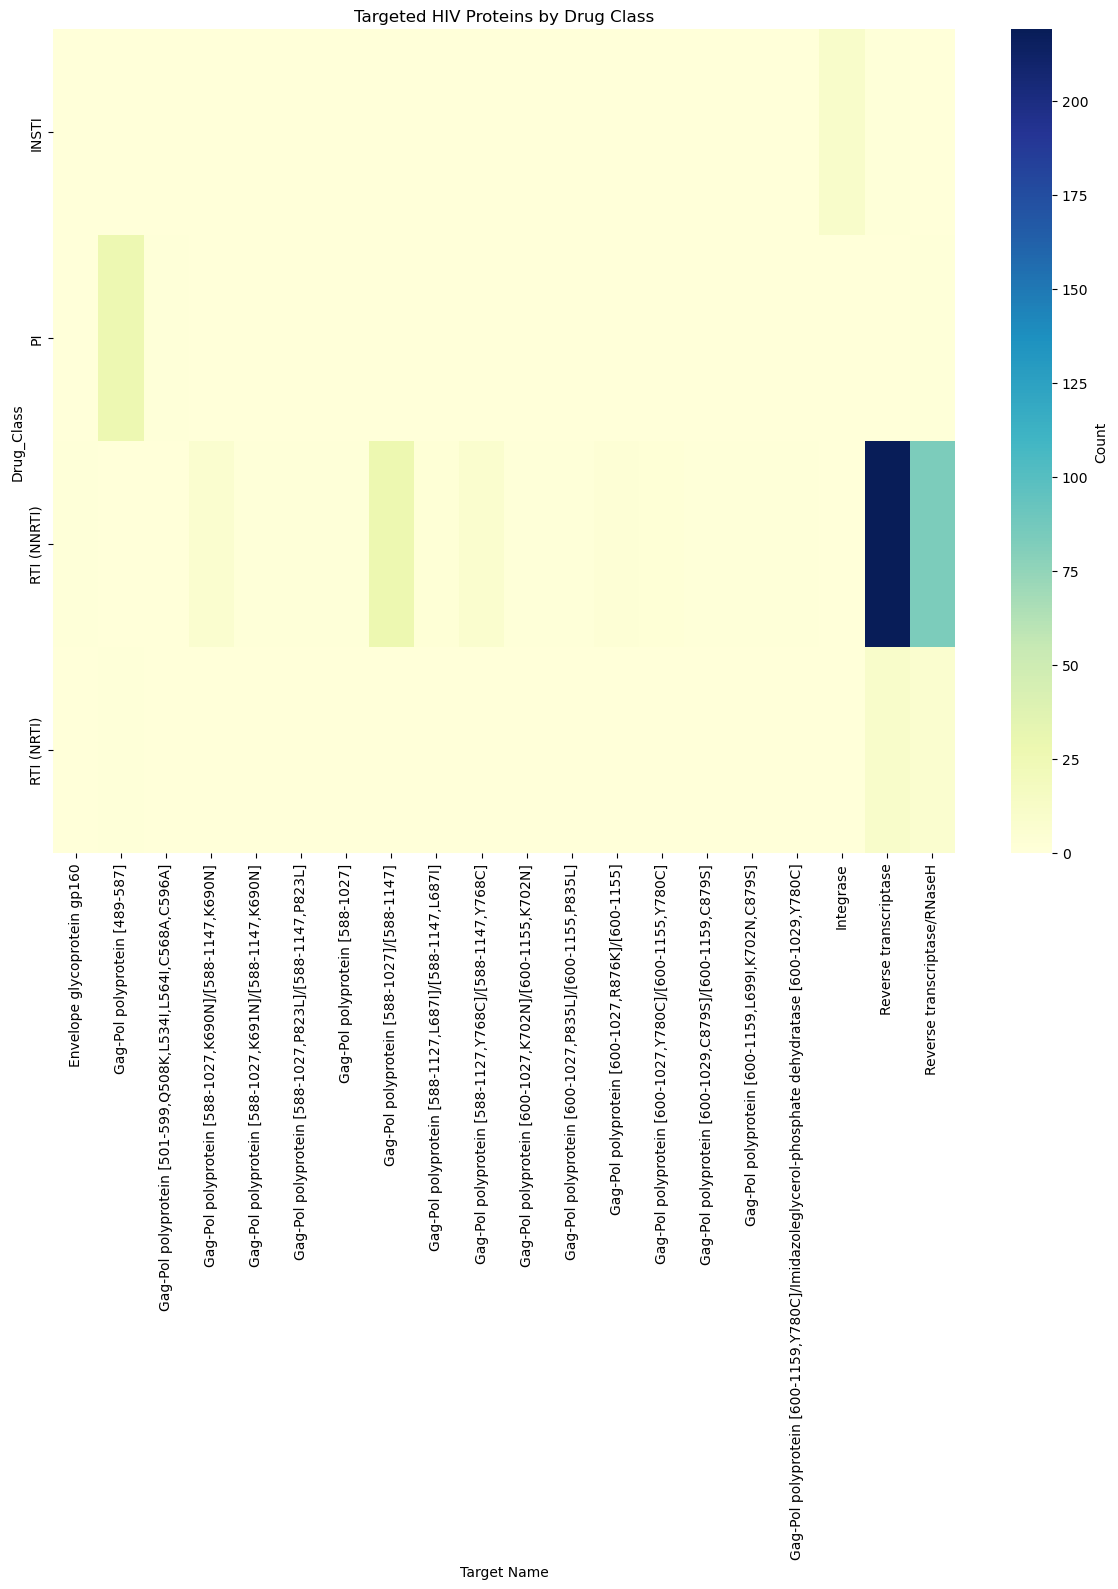

In [146]:
evaluation_utils.plot_protein_target_heatmap(filtered_data, figsize=(12,16))

The plot seems uniform, mostly because Gag-Pol polyprotein is targeted in different locations along its sequence, and mutations are also present. We observe stronger colors for reverse transcriptase, because it is entirely targeted

In [151]:
#some processing for further analyses
filtered_data = pd.merge(filtered_data, doi_df, on='Article DOI', how='outer')
filtered_data = filtered_data.dropna(subset=['IC50 (nM)'])


NameError: name 'doi_df' is not defined

Let's observe now how the different drug classes have been studied throughout the years.

We utilize the publication year as an approximate indicator to explore temporal trends and patterns of discovery across each drug class. It is important to note that the publication year may not directly align with the actual year of discovery, nor does a higher frequency of publications necessarily reflect greater utilization rates in clinical settings.

Historically, **RTIs** (Reverse Transcriptase Inhibitors) and **NNRTIs** (Non-Nucleoside Reverse Transcriptase Inhibitors) were the first antiretroviral drug classes introduced and are still in use today. **INSTIs** (Integrase Strand Transfer Inhibitors) represent the most recent class of antiretrovirals. Our research indicates that **PIs** (Protease Inhibitors) were introduced after RTIs (doi: 10.1016/j.idc.2014.06.001.)

In [ ]:
evaluation_utils.plot_drug_distribution_by_year(filtered_data, year_col='year')

In [ ]:
drug_class_order = ['RTI (NRTI)', 'RTI (NNRTI)', 'PI', 'INSTI']

# Assuming `filtered_data` is your processed DataFrame
evaluation_utils.plot_ic50_by_drug_class(filtered_data, drug_class_col='Drug_Class', ic50_col='IC50 (nM)', 
                        drug_class_order=drug_class_order)

In [ ]:
####what else?? expand the drugs? other analysis? Temporal Trends in Drug Categories:
# 1 Analyze how the focus on different drug categories has evolved over time.
# Plot the number of drugs in each category by year to identify trends or shifts in research focus.
# 2  Mapping Drug Categories to Protein Targets:
# Create a matrix or heatmap showing the relationship between drug categories and their associated protein targets.
# Identify if certain drug classes are more commonly linked to specific targets.
# 3 Correlation Between Affinity and Drug Class:
# Perform statistical tests to evaluate correlations between affinity metrics and drug categories.
# Use hypothesis testing (e.g., ANOVA) to determine if affinity values significantly differ among drug classes.
# 4 Outlier Analysis: 
# see drive


## **Molecular Features**

Following our exploration of drug categories and protein targets, we now focus on Molecular Features, which describe the structural and chemical characteristics of compounds that affect their interactions with biological targets. These features include properties such as molecular weight, hydrogen bond donors and acceptors, lipophilicity, and specific structural motifs, all of which significantly influence the binding affinity of a drug. ###MORO  quali sono esattamente

Understanding molecular features is fundamental to studying binding affinity, as these properties dictate how effectively a drug interacts with its target. Analyzing molecular features can reveal important patterns that contribute to the strength, specificity, and stability of these interactions. This, in turn, aids in the design of more potent and selective therapeutic agents.

To delve deeper into the role of molecular features in drug development, we will examine the key properties of compounds in the dataset and their relationship with binding affinity metrics. This analysis will provide crucial insights into the molecular basis of drug efficacy in the treatment of HIV-1 and other STDs.

In [ ]:
##moro code

## **Institution**

astly, we focus on Institution, which represents the organizations and research centers contributing to drug development for sexually transmitted diseases. Institutions play a key role in shaping scientific progress, with their location, funding, and expertise influencing research priorities and outcomes.

Analyzing institutions helps us understand how regional priorities and resources drive innovation and whether countries most affected by diseases like HIV-1 are leading research efforts. This can also reveal disparities, highlighting areas needing greater attention.

We will examine the contributions of institutions in the dataset to assess their role in drug discovery and their impact on binding affinity research for HIV-1 and other STDs.

In [ ]:
##simo code

# **3) Compartive analysis**

In order to expand our analysis to a broader perspective in the STD world, we would like to compare our results on HIV with another impactful disease: **Hepatitis**.  
Hepatitis refers to the inflammation of the liver, commonly caused by viral infections such as Hepatitis B (HBV) and Hepatitis C (HCV). Hepatitis C, in particular, shares similarities with HIV in terms of transmission routes, such as blood-to-blood contact and shared risk factors like intravenous drug use. Both diseases have significant global health burdens and are major focuses of antiviral drug development. Understanding the differences and similarities in therapeutic strategies for these diseases can provide valuable insights into drug targeting and efficaclts  
Here are the most meaningful results of our comparative analysis:
lysis

In [ ]:
##leonor's code 

# **4) Temporal analysis???**